In [16]:
%matplotlib inline
import os
import csv
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sma
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import sklearn.model_selection as skms
import regression_models as reg_mod

In [30]:
def plot_explore(data, file_name=None):
    """
    :param data: csv data
    :returns : regression coefficients for the two methods 
    """
    #Explore data set
    plt.figure(1)
    reg = reg_mod.ols_reg(data)
    plt.scatter(reg.predict(),reg.resid)
    plt.axhline(y=0.0,color='#A9A9A9',linestyle="--")
    plt.title(file_name)
    plt.xlabel("Fitted Value")
    plt.ylabel("Residual")
    #plt.savefig("figures/explore_figure_"+file_name+".pdf", format="pdf")
    #plt.close()
    plt.show()

def plot_results(data, file_name=None):
    """
    :param data: csv data
    :returns : regression coefficients for the two methods and saves a linear plot
                of the regression coefficient along with scatter plot of the corresponding data
    """
    #Explore data set
#     plt.figure(1)
#     reg = reg_mod.ols_reg(data)
#     plt.scatter(reg.predict(),reg.resid)
#     plt.axhline(y=0.0,color='#A9A9A9',linestyle="--")
#     plt.title(file_name)
#     plt.xlabel("Fitted Value")
#     plt.ylabel("Residual")
#     plt.show()
    #plt.savefig("figures/explore_figure_"+file_name+".pdf", format="pdf")
    #plt.close()

    #Plot results
    x, y = data.x, data.y
    theta_wls, theta_huber = reg_mod.wls_reg(data), reg_mod.huber_reg(data)
    xRange= np.array([x.min(),x.max()])
    y_wls, y_huber = theta_wls[0] + theta_wls[1]*xRange, theta_huber[0] + theta_huber[1]*xRange
    plt.figure(2)
    plt.plot(xRange, y_wls,label="WLS" )
    plt.plot(xRange, y_huber, label="Huber")
    plt.legend()
    plt.scatter(x,y)
    plt.title(file_name)
    plt.xlabel("Predictor")
    plt.ylabel("Response")
    plt.show()
    #plt.savefig("figures/figure_"+file_name+".pdf", format="pdf")
    #plt.close()
    return theta_wls, theta_huber


def plot_evaluataion(eval_data,data_name):
    """
    :param eval_data : evaluation data
    :param data_name : list of data names
    """
    val_mse_wls = eval_data[0:1].values[0]
    val_mse_huber = eval_data[1:2].values[0]
    train_mse_wls = eval_data[2:3].values[0]
    train_mse_huber = eval_data[3:4].values[0]
    fontsize = 11
    width = 0.20
    fig, ax = plt.subplots(figsize=(10,2.75))
    N=len(val_mse_wls)
    ind = np.arange(N) # the x locations for the groups
    rects1 = ax.bar(ind-1.5*width, val_mse_wls, width=width, color='C0', alpha=0.7)
    rects2 = ax.bar(ind-0.5*width, val_mse_huber, width=width, color='C1', alpha=0.7)
    rects3 = ax.bar(ind+0.5*width, train_mse_wls, width=width, color='C2', alpha=0.7)
    rects4 = ax.bar(ind+1.5*width, train_mse_huber, width=width, color='C3', alpha=0.7)
    # add some text for labels, title and axes ticks
    ax.set_ylabel('Normalized Average RMSE',fontsize=fontsize) 
    ax.set_xticks(ind )
    ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), ('WLS_test', 'Huber_test','WLS_train', 'Huber_train'),fontsize=fontsize-2,loc='center left', bbox_to_anchor=(0.02, 1.08), ncol=4)
    ax.set_xticklabels(data_name)
    ax.tick_params(labelsize=fontsize)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.show()
    #plt.savefig('figures/evaluation_bar.pdf',format = 'pdf')
    #plt.close()


def model_evaluation(data, num_splits=4):
    """
    :param data : csv data
    :param num_splits: number of splits for cross validation 
    """
    def fmse(y,y_pred):
        return np.sqrt(np.mean((y-y_pred)**2))/np.max(y-y_pred)

    x, y = data.x, data.y
    wls_mse_train, wls_mse_val, huber_mse_train, huber_mse_val = 0.0, 0.0, 0.0, 0.0
    for train, val in skms.KFold(n_splits=num_splits).split(X=x, y=y):
        val_data = pd.DataFrame(data = {'x':x[val],'y':y[val]})
        train_data = pd.DataFrame(data = {'x':x[train],'y':y[train]})

        theta_huber = np.array(reg_mod.huber_reg(train_data))
        theta_wls = np.array(reg_mod.wls_reg(train_data))
        #Test
        wls_pred_val = np.dot(sma.add_constant(val_data.x),theta_wls)
        huber_pred_val = np.dot(sma.add_constant(val_data.x),theta_huber)
        wls_mse_val += fmse(y=val_data.y,y_pred=wls_pred_val)/num_splits
        huber_mse_val += fmse(y=val_data.y,y_pred=huber_pred_val)/num_splits
        #Train
        wls_pred_train = np.dot(sma.add_constant(train_data.x),theta_wls)
        huber_pred_train = np.dot(sma.add_constant(train_data.x),theta_huber)
        wls_mse_train += fmse(y=train_data.y,y_pred=wls_pred_train)/num_splits
        huber_mse_train +=fmse(y=train_data.y,y_pred=huber_pred_train)/num_splits
    return [wls_mse_val, huber_mse_val, wls_mse_train, huber_mse_train]



In [18]:
def get_data(data_path):
    all_data = {}
    for dirpath, dirnames, filenames in os.walk(data_path):
        for file in filenames:
            file_prefix = file[:-4]
            if file.endswith(".csv") and file[:5]=='data_':
                file_path = os.path.join(data_path,file)
                data = pd.read_csv(file_path)
                all_data[file_prefix]= data
    return all_data


#
#     except FileExistsError:
#         print("Directory already exits")

#     print("Generating plots.......")
#     print("Evaluating models......")

#     all_data = {}
#     for dirpath, dirnames, filenames in os.walk(data_path):
#         for file in filenames:
#             file_prefix = file[:-4]
#             if file.endswith(".csv") and file[:5]=='data_':
#                 file_path = os.path.join(data_path,file)
#                 data = pd.read_csv(file_path)
#                 all_data[file_prefix]= data

#     eval_data = {}
#     data_name = []
#     with open("results.csv","w") as csvfile:
#         fieldnames = ["data","a estimate", "b estimate", "method"]
#         writer = csv.DictWriter(csvfile,fieldnames=fieldnames)
#         writer.writeheader()
#         cnt= 1
#         for fname, fdata in all_data.items():
#             data_name.append(fname)
#             wls, huber = self.plot_results(fdata, fname)
#             writer.writerow({"data":fname, "a estimate":wls[1], "b estimate":wls[0], "method":"WLS"})
#             writer.writerow({"data":fname, "a estimate":huber[1], "b estimate":huber[0], "method":"Huber"})
#     

## Exploratory Data Analysis

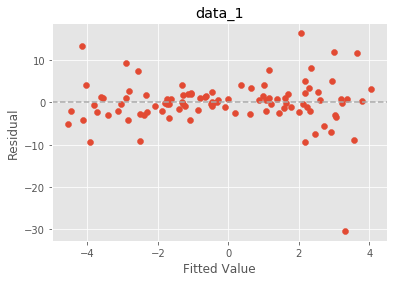

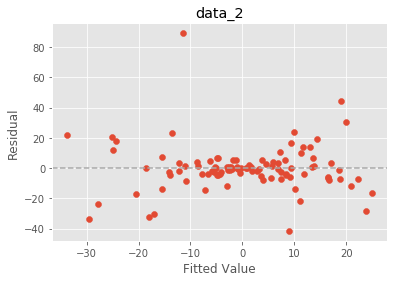

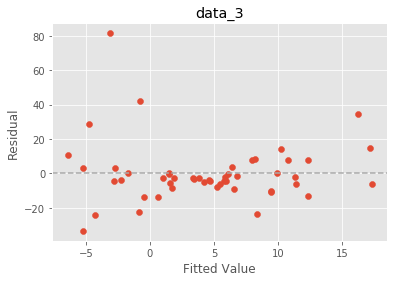

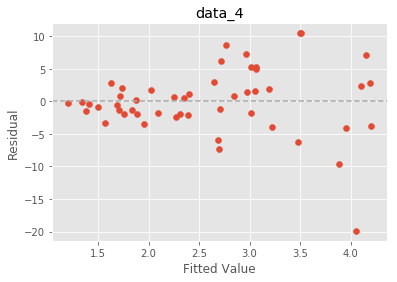

In [24]:
data_path = "./data"
all_data= get_data(data_path)
for fname, fdata in sorted(all_data.items()):
        plot_explore(fdata,fname)

## Plot Results

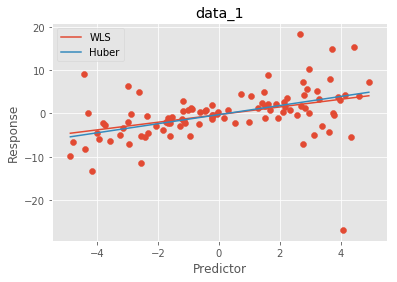

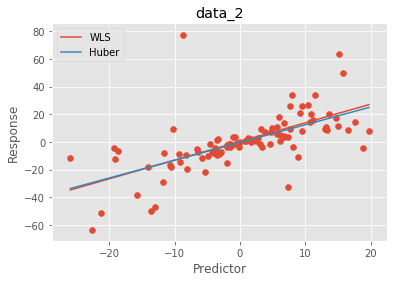

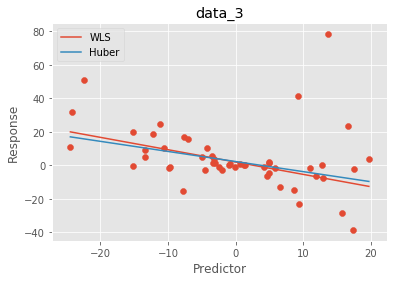

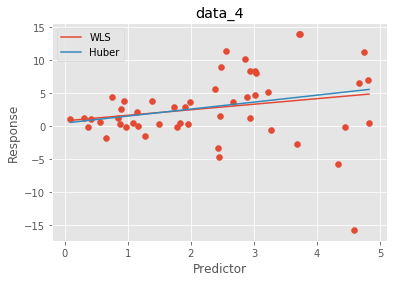

In [32]:
eval_data = {}
data_name = []
for fname, fdata in sorted(all_data.items()):
        data_name.append(fname)
        plot_results(fdata, fname)
        eval_data[fname]=model_evaluation(fdata)

## Evaluate Results

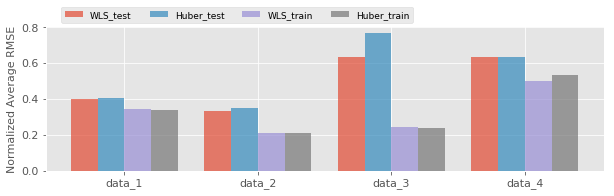

In [35]:
df_eval_data = pd.DataFrame(data=eval_data)
data_name = sorted(data_name)
df_eval_data=df_eval_data[data_name]
plot_evaluataion(df_eval_data, data_name)